In [2]:
import pandas as pd
import numpy as np
import pylab as p
import matplotlib.pyplot as plot
from collections import Counter
from load_data import load_financial_data, load_sentiment_data
import re

#importing packages for the prediction of time-series data
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from statsmodels.tsa.arima_model import ARIMA


In [13]:
# Load the data for Bitcoin
df_financials = load_financial_data(filepath = 'data/top20_aggre_price_reduced.csv', start_date = '2017-07-28', end_date = '2018-07-27', tickers = 'BTC')
#df_financials = aggregate_financials(df_financials)

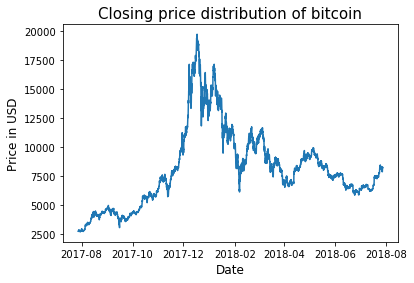

In [14]:
# Plot the Bitcoin prices to check for Stationarity
plot.plot(df_financials)
plot.xlabel('Date', fontsize=12)
plot.ylabel('Price in USD', fontsize=12)
plot.title("Price distribution of bitcoin", fontsize=15)
plot.show()

In [15]:
# Test financial values for random walk -> can not reject 0 hypothesis that it is a random walk
from statsmodels.tsa.stattools import adfuller

# Run the ADF test on the price series and print out the results
results = adfuller(df_financials)
print(results)

# Just print out the p-value
print('The p-value of the test on prices is: ' + str(results[1]))

(-1.8247292247966496, 0.36825526083088994, 33, 8726, {'1%': -3.4310996246527132, '5%': -2.8618712841785983, '10%': -2.5669463376015962}, 100389.39139712123)
The p-value of the test on prices is: 0.368255260831


In [16]:
# Test financial returns for random walk -> can reject 0 hypothesis that it is a random walk
from statsmodels.tsa.stattools import adfuller

# Create a DataFrame of AMZN returns
df_financials_ret = df_financials.pct_change()

# Eliminate the NaN in the first row of returns
df_financials_ret = df_financials_ret.dropna()

# Run the ADF test on the return series and print out the p-value
results = adfuller(df_financials_ret)
print('The p-value of the test on returns is: ' + str(results[1]))

The p-value of the test on returns is: 2.66707746643e-30


In [17]:
# Augmented Dicky Fuller Test for Stationarity
from statsmodels.tsa.stattools import adfuller

def test_stationarity(x):


    #Determing rolling statistics
    rolmean = x.rolling(window=22,center=False).mean()

    rolstd = x.rolling(window=12,center=False).std()
    
    #Plot rolling statistics:
    orig = plot.plot(x, color='blue',label='Original')
    mean = plot.plot(rolmean, color='red', label='Rolling Mean')
    std = plot.plot(rolstd, color='black', label = 'Rolling Std')
    plot.legend(loc='best')
    plot.title('Rolling Mean & Standard Deviation')
    plot.show(block=False)
    
    #Perform Dickey Fuller test    
    result=adfuller(x)
    print('ADF Stastistic: %f'%result[0])
    print('p-value: %f'%result[1])
    pvalue=result[1]
    for key,value in result[4].items():
         if result[0]>value:
            print("The graph is non stationery")
            break
         else:
            print("The graph is stationery")
            break;
    print('Critical values:')
    for key,value in result[4].items():
        print('\t%s: %.3f ' % (key, value))


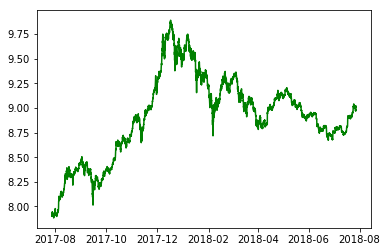

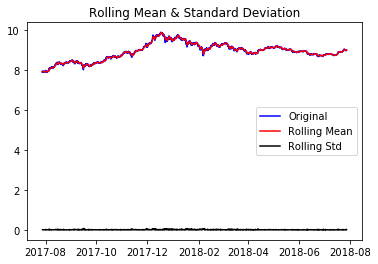

ADF Stastistic: -2.353879
p-value: 0.155179
The graph is non stationery
Critical values:
	1%: -3.431 
	5%: -2.862 
	10%: -2.567 


In [18]:
# Log transform the series to unskew data
ts_log = np.log(df_financials)
plot.plot(ts_log, color = 'green')
plot.show()

test_stationarity(ts_log)

In [ ]:
# Differnciating
ts_log_diff = ts_log - ts_log.shift()
plot.plot(ts_log_diff)
plot.show()

ts_log_diff.dropna(inplace = True)
test_stationarity(ts_log_diff)

In [ ]:
# Autocorrelation
from pandas import Series
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_acf
series = ts_log_diff
plot_acf(series, lags=50)
pyplot.show()

In [ ]:
# Partial Autocorrelation
from pandas import Series
from matplotlib import pyplot
from statsmodels.graphics.tsaplots import plot_pacf
series = ts_log_diff
plot_pacf(series, lags=50)
pyplot.show()

In [ ]:
# Use Auto Regressive model with lag = 4 
# follow lag
model = ARIMA(ts_log, order=(4,1,0))  
results_ARIMA = model.fit(disp=-1)  
plot.plot(ts_log_diff)
plot.plot(results_ARIMA.fittedvalues, color='red')
plot.title('RSS: %.7f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))
plot.show()

In [ ]:
# Use Moving Average Model
model = ARIMA(ts_log, order=(0,1,1))  
results_MA = model.fit(disp=-1)  
plot.plot(ts_log_diff)
plot.plot(results_MA.fittedvalues, color='red')
plot.title('RSS: %.7f'% sum((results_MA.fittedvalues-ts_log_diff)**2))
plot.show()

In [ ]:
# Using full ARIMA
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(ts_log, order=(2,1,0))  
results_ARIMA = model.fit(disp=-1)  
plot.plot(ts_log_diff)
plot.plot(results_ARIMA.fittedvalues, color='red')
plot.title('RSS: %.7f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))
plot.show()

In [5]:
# Use AR model (it performed best)

size = int(len(ts_log)*0.9)
# Divide into train and test
train_arima, test_arima = ts_log[0:size], ts_log[size:len(ts_log)]
history = [x for x in train_arima]
evaluation = pd.DataFrame(index=range(0,len(test_arima)), columns=[['pred', 'exp', 'error %']])
predictions = list()
originals = list()
error_list = list()



print('Printing Predicted vs Expected Values...')
print('\n')
# We go over each value in the test set and then apply ARIMA model and calculate the predicted value. We have the expected value in the test set therefore we calculate the error between predicted and expected value 
for t in range(len(test_arima)):
    model = ARIMA(history, order=(4, 1, 0))
    model_fit = model.fit(disp=-1)
    
    output = model_fit.forecast()
    
    pred_value = output[0]
    
        
    original_value = test_arima[t]
    history.append(original_value)
    
    pred_value = np.exp(pred_value)
    original_value = np.exp(original_value)
    
    # Calculating the error
    error = ((abs(pred_value - original_value)) / original_value) * 100
    
    # Lists for plots
    error_list.append(error)
    predictions.append(float(pred_value))
    originals.append(float(original_value))
    
    # Data Frame for output table
    evaluation.iloc[t][0] = pred_value
    evaluation.iloc[t][1] = original_value
    evaluation.iloc[t][2] = error

    print('predicted = %f,   expected = %f,   error = %f ' % (pred_value, original_value, error), '%')
    

    


Printing Predicted vs Expected Values...


predicted = 6725.438382,   expected = 6730.052500,   error = 0.068560  %
predicted = 6734.797148,   expected = 6719.005000,   error = 0.235037  %
predicted = 6713.188477,   expected = 6723.255000,   error = 0.149727  %
predicted = 6729.121011,   expected = 6726.962500,   error = 0.032087  %
predicted = 6726.923713,   expected = 6722.835000,   error = 0.060818  %
predicted = 6721.628156,   expected = 6718.510000,   error = 0.046411  %
predicted = 6718.505348,   expected = 6713.660000,   error = 0.072171  %
predicted = 6712.053665,   expected = 6714.535000,   error = 0.036955  %
predicted = 6716.903343,   expected = 6723.702500,   error = 0.101122  %
predicted = 6728.425789,   expected = 6718.330000,   error = 0.150272  %
predicted = 6713.291168,   expected = 6725.100000,   error = 0.175593  %
predicted = 6732.877911,   expected = 6725.707500,   error = 0.106612  %
predicted = 6722.325203,   expected = 6723.902500,   error = 0.023458  %
predicte

predicted = 6244.652977,   expected = 6252.500000,   error = 0.125502  %
predicted = 6257.962629,   expected = 6266.430000,   error = 0.135123  %
predicted = 6272.195510,   expected = 6260.677500,   error = 0.183974  %
predicted = 6253.253510,   expected = 6243.215000,   error = 0.160791  %
predicted = 6238.606437,   expected = 6229.370000,   error = 0.148272  %
predicted = 6226.291566,   expected = 6211.930000,   error = 0.231193  %
predicted = 6205.263348,   expected = 6220.895000,   error = 0.251277  %
predicted = 6231.594319,   expected = 6224.897500,   error = 0.107581  %
predicted = 6222.345298,   expected = 6221.632500,   error = 0.011457  %
predicted = 6222.160687,   expected = 6208.730000,   error = 0.216319  %
predicted = 6203.299617,   expected = 6189.350000,   error = 0.225381  %
predicted = 6183.002318,   expected = 6196.742500,   error = 0.221732  %
predicted = 6206.147689,   expected = 6205.490000,   error = 0.010598  %
predicted = 6205.628924,   expected = 6202.015000, 

predicted = 6339.946690,   expected = 6334.880000,   error = 0.079981  %
predicted = 6333.328292,   expected = 6368.087500,   error = 0.545834  %
predicted = 6388.800935,   expected = 6384.355000,   error = 0.069638  %
predicted = 6379.601246,   expected = 6352.290000,   error = 0.429943  %
predicted = 6336.654825,   expected = 6344.330000,   error = 0.120977  %
predicted = 6351.950354,   expected = 6344.172500,   error = 0.122598  %
predicted = 6340.015085,   expected = 6345.372500,   error = 0.084430  %
predicted = 6348.043747,   expected = 6365.430000,   error = 0.273136  %
predicted = 6377.088854,   expected = 6369.627500,   error = 0.117140  %
predicted = 6365.384736,   expected = 6361.862500,   error = 0.055365  %
predicted = 6360.243092,   expected = 6362.530000,   error = 0.035943  %
predicted = 6365.093403,   expected = 6353.467500,   error = 0.182985  %
predicted = 6346.981507,   expected = 6350.280000,   error = 0.051942  %
predicted = 6353.138972,   expected = 6358.680000, 

predicted = 6601.511149,   expected = 6607.647500,   error = 0.092867  %
predicted = 6612.979740,   expected = 6579.052500,   error = 0.515686  %
predicted = 6560.411886,   expected = 6523.707500,   error = 0.562631  %
predicted = 6508.050157,   expected = 6496.942500,   error = 0.170967  %
predicted = 6495.944665,   expected = 6508.137500,   error = 0.187348  %
predicted = 6516.743041,   expected = 6502.560000,   error = 0.218115  %
predicted = 6496.207234,   expected = 6520.532500,   error = 0.373056  %
predicted = 6537.137950,   expected = 6541.000000,   error = 0.059044  %
predicted = 6544.080918,   expected = 6537.665000,   error = 0.098138  %
predicted = 6532.887815,   expected = 6526.395000,   error = 0.099485  %
predicted = 6524.118835,   expected = 6532.040000,   error = 0.121266  %
predicted = 6537.132690,   expected = 6539.397500,   error = 0.034633  %
predicted = 6540.110898,   expected = 6519.837500,   error = 0.310949  %
predicted = 6509.299967,   expected = 6517.710000, 

predicted = 6601.933916,   expected = 6522.742500,   error = 1.214082  %
predicted = 6481.491700,   expected = 6461.397500,   error = 0.310988  %
predicted = 6458.014214,   expected = 6413.187500,   error = 0.698977  %
predicted = 6395.081411,   expected = 6365.737500,   error = 0.460966  %
predicted = 6353.943019,   expected = 6381.835000,   error = 0.437053  %
predicted = 6404.575527,   expected = 6379.417500,   error = 0.394362  %
predicted = 6368.627244,   expected = 6384.525000,   error = 0.249005  %
predicted = 6395.785668,   expected = 6377.092500,   error = 0.293130  %
predicted = 6369.895656,   expected = 6367.380000,   error = 0.039509  %
predicted = 6366.411856,   expected = 6379.555000,   error = 0.206020  %
predicted = 6388.216989,   expected = 6378.415000,   error = 0.153674  %
predicted = 6372.876069,   expected = 6387.905000,   error = 0.235272  %
predicted = 6396.966863,   expected = 6388.687500,   error = 0.129594  %
predicted = 6384.918395,   expected = 6375.230000, 

predicted = 6259.843702,   expected = 6259.347500,   error = 0.007927  %
predicted = 6260.489428,   expected = 6263.765000,   error = 0.052294  %
predicted = 6266.334793,   expected = 6278.120000,   error = 0.187719  %
predicted = 6285.216973,   expected = 6289.332500,   error = 0.065437  %
predicted = 6291.465549,   expected = 6296.182500,   error = 0.074918  %
predicted = 6298.541274,   expected = 6293.767500,   error = 0.075849  %
predicted = 6291.237462,   expected = 6318.882500,   error = 0.437499  %
predicted = 6333.947774,   expected = 6326.360000,   error = 0.119939  %
predicted = 6320.852279,   expected = 6345.857500,   error = 0.394040  %
predicted = 6358.936253,   expected = 6359.900000,   error = 0.015153  %
predicted = 6360.058189,   expected = 6356.397500,   error = 0.057591  %
predicted = 6352.868856,   expected = 6357.650000,   error = 0.075203  %
predicted = 6360.812569,   expected = 6364.045000,   error = 0.050792  %
predicted = 6365.602297,   expected = 6376.690000, 

predicted = 7437.485859,   expected = 7449.450000,   error = 0.160604  %
predicted = 7456.547300,   expected = 7449.805000,   error = 0.090503  %
predicted = 7447.775444,   expected = 7440.920000,   error = 0.092132  %
predicted = 7437.535881,   expected = 7483.777500,   error = 0.617891  %
predicted = 7509.135387,   expected = 7478.860000,   error = 0.404813  %
predicted = 7459.981284,   expected = 7438.165000,   error = 0.293302  %
predicted = 7427.295425,   expected = 7435.775000,   error = 0.114038  %
predicted = 7444.794454,   expected = 7462.777500,   error = 0.240970  %
predicted = 7471.852903,   expected = 7459.580000,   error = 0.164525  %
predicted = 7452.136308,   expected = 7457.355000,   error = 0.069980  %
predicted = 7463.069742,   expected = 7438.845000,   error = 0.325652  %
predicted = 7427.326412,   expected = 7398.870000,   error = 0.384605  %
predicted = 7384.487553,   expected = 7410.430000,   error = 0.350080  %
predicted = 7428.327068,   expected = 7465.690000, 

predicted = 8218.559341,   expected = 8234.267500,   error = 0.190766  %
predicted = 8236.154908,   expected = 8211.857500,   error = 0.295882  %
predicted = 8195.771328,   expected = 8196.550000,   error = 0.009500  %
predicted = 8196.623831,   expected = 8176.387500,   error = 0.247497  %
predicted = 8162.946487,   expected = 8179.507500,   error = 0.202470  %
predicted = 8188.325346,   expected = 8216.567500,   error = 0.343722  %
predicted = 8233.908881,   expected = 8239.312500,   error = 0.065583  %
predicted = 8241.508394,   expected = 8262.102500,   error = 0.249260  %
predicted = 8273.558806,   expected = 8232.440000,   error = 0.499473  %
predicted = 8210.029323,   expected = 8233.017500,   error = 0.279219  %
predicted = 8246.696683,   expected = 8285.625000,   error = 0.469830  %
predicted = 8307.116480,   expected = 8377.177500,   error = 0.836332  %
predicted = 8411.429630,   expected = 8415.975000,   error = 0.054009  %
predicted = 8414.560587,   expected = 8411.540000, 

In [32]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 8758
Model:                 ARIMA(4, 1, 0)   Log Likelihood               30433.467
Method:                       css-mle   S.D. of innovations              0.007
Date:                Wed, 06 Mar 2019   AIC                         -60854.934
Time:                        16:32:27   BIC                         -60812.467
Sample:                             1   HQIC                        -60840.464
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0001      0.000      1.150      0.250   -8.95e-05       0.000
ar.L1.D.y      0.5380      0.011     50.551      0.000       0.517       0.559
ar.L2.D.y     -0.3547      0.012    -29.711      0.000      -0.378      -0.331
ar.L3.D.y      0.1817      0.012     15.219      0.000       0.158       0.205
ar.L4.D.y     -0.0901      0.011     -8.471      0.000      -0.111      -0.069
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.4648           -1.7103j            1.7723           -0.2922
AR.2           -0.4648           +1.7103j            1.7723            0.2922
AR.3            1.4727           -1.1676j            1.8794           -0.1067
AR.4            1.4727           +1.1676j            1.8794            0.1067
-----------------------------------------------------------------------------
"""

In [27]:
evaluation.to_csv('evaluation_ARIMA_4_1_0_10_percent_test.csv')


 Mean Error in Predicting Test Case Articles : 0.259050  %


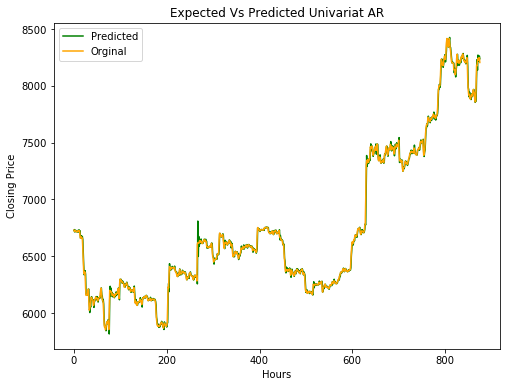

In [28]:
# After iterating over whole test set the overall mean error is calculated.   
print('\n Mean Error in Predicting Test Case Articles : %f ' % (sum(error_list)/float(len(error_list))), '%')
plot.figure(figsize=(8, 6))
test_day = [t for t in range(len(test_arima))]
labels={'Orginal','Predicted'}
plot.plot(test_day, predictions, color= 'green')
plot.plot(test_day, originals, color = 'orange')
plot.title('Expected Vs Predicted Univariat AR')
plot.xlabel('Hours')
plot.ylabel('Closing Price')
plot.legend(labels)
plot.show()

array([ 0.31371696])